In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap

from sdm.config import get_db_connection
from sdm.crud_embeddings import get_all_embeddings

d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

In [2]:
with get_db_connection(db_type="postgres") as db:
    df = get_all_embeddings(db)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36780 entries, 0 to 36779
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         36780 non-null  int64 
 1   text       36780 non-null  object
 2   doc_type   36780 non-null  object
 3   doc_id     36780 non-null  object
 4   embedding  36780 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [3]:
embeddings = df["embedding"].to_list()
# print(embeddings[:3])

[[-0.13590758, 0.17315766, -0.008780155, 0.11632208, -0.012016799, -0.012617953, -0.038514487, 0.0045306366, 0.048643872, 0.10428113, 0.058138195, 0.09280491, 0.011615371, 0.19934353, 0.002482957, -0.22126144, 0.120349556, -0.15641834, -0.13506147, 0.03831738, 0.07036269, 0.0023299714, 0.045295514, -0.018470116, 0.045658488, 0.04920253, -0.10747731, 0.0024857086, -0.0033550775, 0.035072953, 0.24630222, 0.1815871, -0.102402836, -0.010709968, -0.041994408, -0.0864753, -0.00995717, 0.04875935, -0.0026413975, 0.019344833, -0.066877425, -0.08168421, 0.00073864055, 0.021253286, -0.16270185, -0.0045262137, 0.18525955, 0.071863525, -0.05045957, -0.17523423, 0.0649199, 0.10796162, -0.022994852, -0.01891617, -0.045550924, -0.04024893, 0.08474456, 0.042516626, -0.124891356, -0.09131727, 0.09471063, 0.15642628, 0.07884395, -0.04407005, 0.06373931, -0.055011272, -0.08639069, -0.13339633, -0.10301088, 0.03823513, 0.07904602, 0.13025406, -0.050870143, 0.048494373, 0.019016031, -0.17730016, -0.1058263

d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\UU\Sem3\SDM\social_data_mining\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


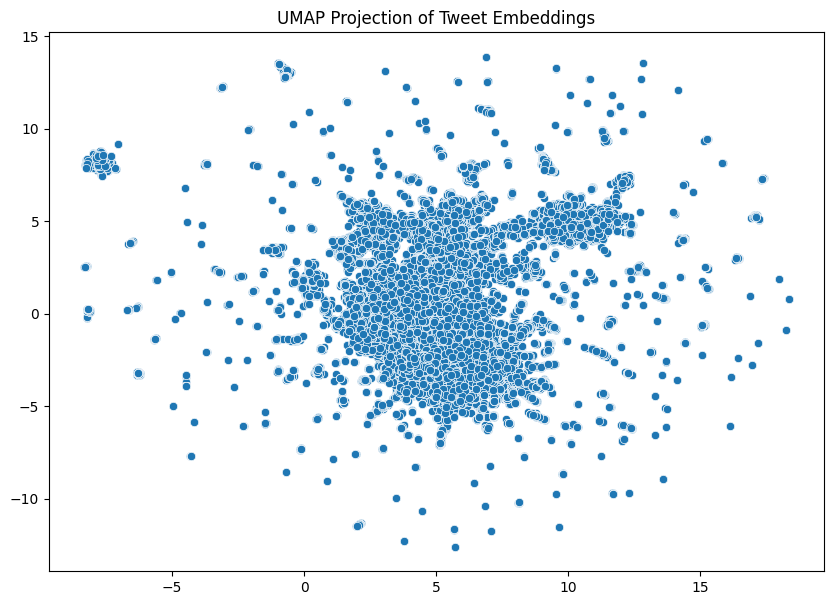

In [9]:
reducer = umap.UMAP(n_neighbors=7, n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1])
plt.title("UMAP Projection of Tweet Embeddings")
plt.show()

In [11]:
def k_distances2(X,n):
    neighbors = NearestNeighbors(n_neighbors=n)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    return distances, indices

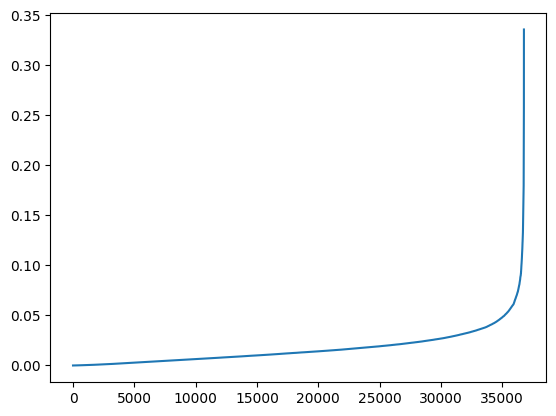

In [21]:
distances, indices = k_distances2(reduced_embeddings,7)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)
plt.show()

In [22]:
with open('distances_reduced.txt', 'w') as f:
    for d in distances:
        f.write(f"{d}\n")

In [27]:
dbscan = DBSCAN(eps=0.05, min_samples=7).fit(reduced_embeddings)
labels_dbscan = dbscan.labels_
n_clusters_ = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_ = list(labels_dbscan).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 762
Estimated number of noise points: 8742


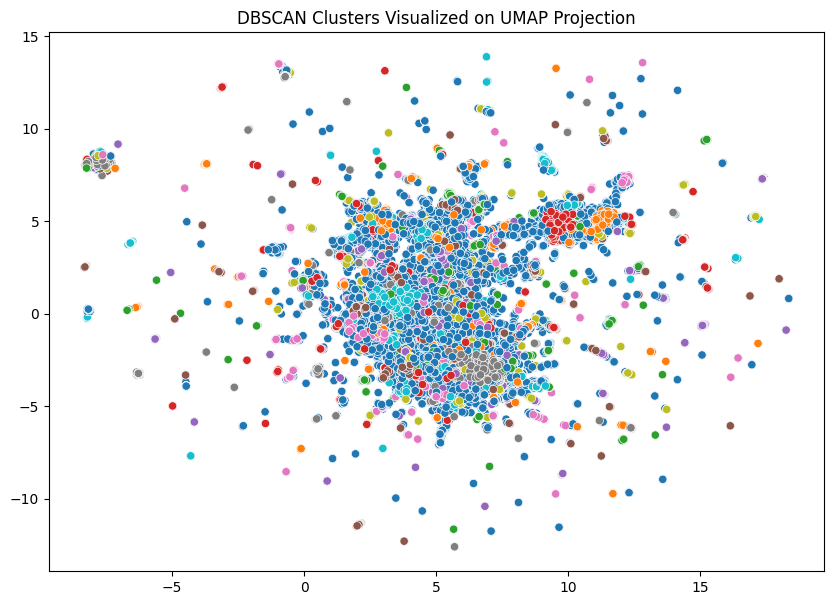

In [28]:
# Plot UMAP projection with DBSCAN clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=labels_dbscan,
    palette="tab10",
    legend=False
)
plt.title("DBSCAN Clusters Visualized on UMAP Projection")
plt.show()

In [29]:
df["labels_dbscan"] = labels_dbscan

print(df["labels_dbscan"].value_counts())

labels_dbscan
-1      8742
 26     1958
 8      1570
 462    1268
 150    1262
        ... 
 647       4
 639       4
 354       4
 613       3
 695       3
Name: count, Length: 763, dtype: int64


In [30]:
print(df[['text', 'labels_dbscan']].head())

                                                text  labels_dbscan
0  $1 trillion funding gap for poorest countries’...            301
1  $3.4 Trillion: #Fossil ]Fuel Divestment Commit...              0
2  $3.4 Trillion: #Fossil ]Fuel Divestment Commit...              0
3  $#COP21, Sassou Nguesso franc et direct. #sass...              1
4  $#COP21: Suivons les négociations et nous verr...              2


In [43]:
for _, d in df[df["labels_dbscan"] == 354].iterrows():
    print("--"*20)
    print(d["doc_type"])
    print(d["text"])

----------------------------------------
tweet
Conf presse @fondationhulot aussi à suivre en direct à 9h30 sur https://t.co/UQceiedMYr salle 3 #LT #COP21 https://t.co/TfcFqtZNWb
----------------------------------------
tweet
Rv à 11h sur @itele @fondationhulot #COP21 https://t.co/tVAMkXWKiC
----------------------------------------
tweet
Rv conf de presse @fondationhulot à 9h30 salle de presse 3 #COP21 https://t.co/N9HEVZeLyO
----------------------------------------
tweet
Rv en direct sur @LCI à 12h35 #COP21 @fondationhulot https://t.co/NR0vJ0kcha


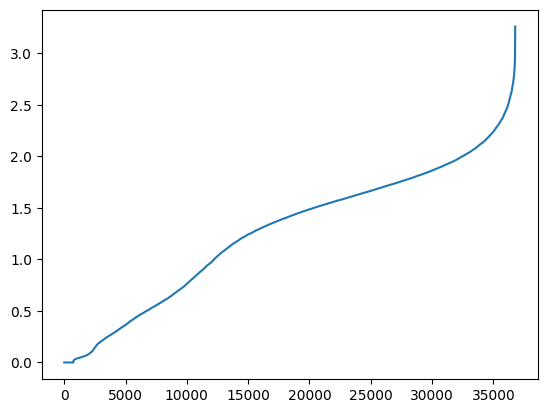

In [44]:
e_distances, e_indices = k_distances2(embeddings,7)
e_distances = np.sort(e_distances, axis=0)
e_distances = e_distances[:,1]

plt.plot(e_distances)
plt.show()

In [49]:
e_distances.mean()

1.268727624190722

In [72]:
e_dbscan = DBSCAN(eps=1.8, min_samples=7).fit(embeddings)
e_labels_dbscan = e_dbscan.labels_
en_clusters_ = len(set(e_labels_dbscan)) - (1 if -1 in e_labels_dbscan else 0)
en_noise_ = list(e_labels_dbscan).count(-1)

print("Estimated number of clusters: %d" % en_clusters_)
print("Estimated number of noise points: %d" % en_noise_)

Estimated number of clusters: 18
Estimated number of noise points: 11087


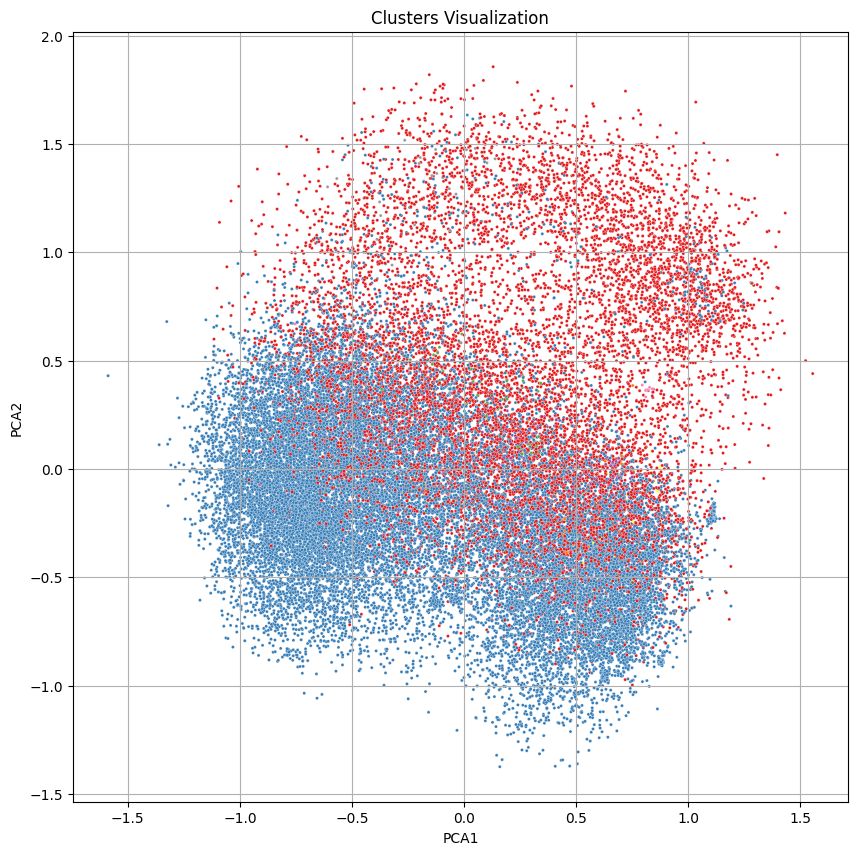

In [73]:
df["e_labels"] = e_labels_dbscan

pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)

df["PCA1"] = pca_embeddings[:, 0]
df["PCA2"] = pca_embeddings[:, 1]

plt.figure(figsize=(10, 10))
sns.scatterplot(x='PCA1', y='PCA2', hue='e_labels', palette='Set1', data=df, s=5, legend=False)
plt.title('Clusters Visualization')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.grid(True)
plt.show()

In [74]:
print(df["e_labels"].value_counts())

e_labels
 0     24682
-1     11087
 14      643
 3        96
 2        69
 1        64
 9        23
 16       21
 12       14
 4        13
 8         9
 11        8
 5         8
 10        8
 17        7
 6         7
 13        7
 7         7
 15        7
Name: count, dtype: int64


In [75]:
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(np.array(embeddings)) # tsne does not like list of lists :/

df['TSNE1'] = tsne_embeddings[:, 0]
df['TSNE2'] = tsne_embeddings[:, 1]

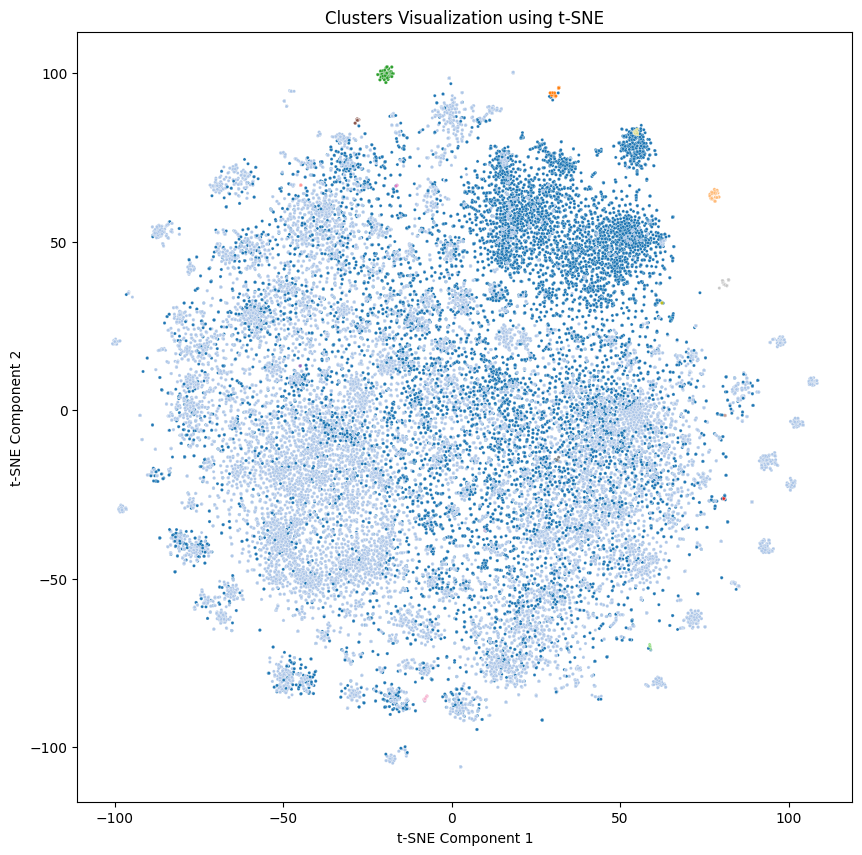

In [76]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='e_labels', palette='tab20', data=df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [77]:
t_dbscan = DBSCAN(eps=1.8, min_samples=7).fit(tsne_embeddings)
t_labels_dbscan = t_dbscan.labels_
tn_clusters_ = len(set(t_labels_dbscan)) - (1 if -1 in t_labels_dbscan else 0)
tn_noise_ = list(t_labels_dbscan).count(-1)

print("Estimated number of clusters: %d" % tn_clusters_)
print("Estimated number of noise points: %d" % tn_noise_)

Estimated number of clusters: 230
Estimated number of noise points: 1208


In [78]:
df["t_labels"] = t_labels_dbscan

# df['TSNE1'] = tsne_embeddings[:, 0]
# df['TSNE2'] = tsne_embeddings[:, 1]

print(df["t_labels"].value_counts())

t_labels
 3      21027
 61      3519
-1       1208
 214      642
 0        469
        ...  
 141        6
 201        6
 187        5
 229        2
 105        1
Name: count, Length: 231, dtype: int64


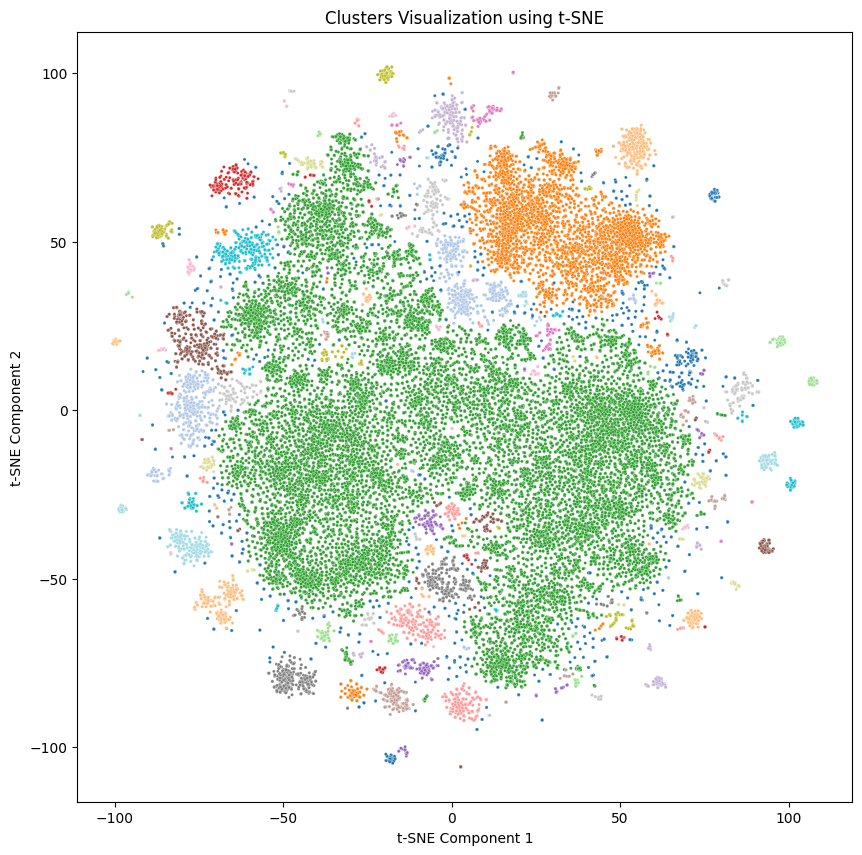

In [79]:
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='TSNE1', y='TSNE2', hue='t_labels', palette='tab20', data=df, s=5, legend=False)

plt.title('Clusters Visualization using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()